In [2]:
import pandas as pd
import matplotlib as pltl
import seaborn as sns
from dataclasses import dataclass
from math import log
from typing import Dict, Iterable, Tuple

from click.formatting import iter_rows

In [3]:
pl = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/eng-premier_league_schedule_updated.csv')
laliga = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/esp-la_liga_schedule_updated.csv')
bl = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/ger-bundesliga_schedule_updated.csv')
fra = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/fra-ligue_1_schedule_updated.csv')
ita = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/processed/ita-serie_a_schedule_updated.csv')
# only keep rows where xg is not na
pl = pl[pl['home_xg'].notna()]
laliga = laliga[laliga['home_xg'].notna()]
bl = bl[bl['home_xg'].notna()]
fra = fra[fra['home_xg'].notna()]
ita = ita[ita['home_xg'].notna()]


In [4]:
# concat all dataframes
df = pd.concat([pl, laliga, bl, fra, ita])
df["date"] = pd.to_datetime(df["date"])

In [5]:
df['score'] = df['score'].astype(str).str.strip()
# Normalize dash characters
df['score'] = df['score'].str.replace('[–—−]', '-', regex=True)

# Split into home and away goals
goals = df['score'].str.split('-', expand=True)
df['home_goals'] = goals[0].astype(int)
df['away_goals'] = goals[1].astype(int)


In [6]:
# sum off xg for home and away
df['total_xg'] = df['home_xg'] + df['away_xg']
df['total_goals'] = df['home_goals'] + df['away_goals']

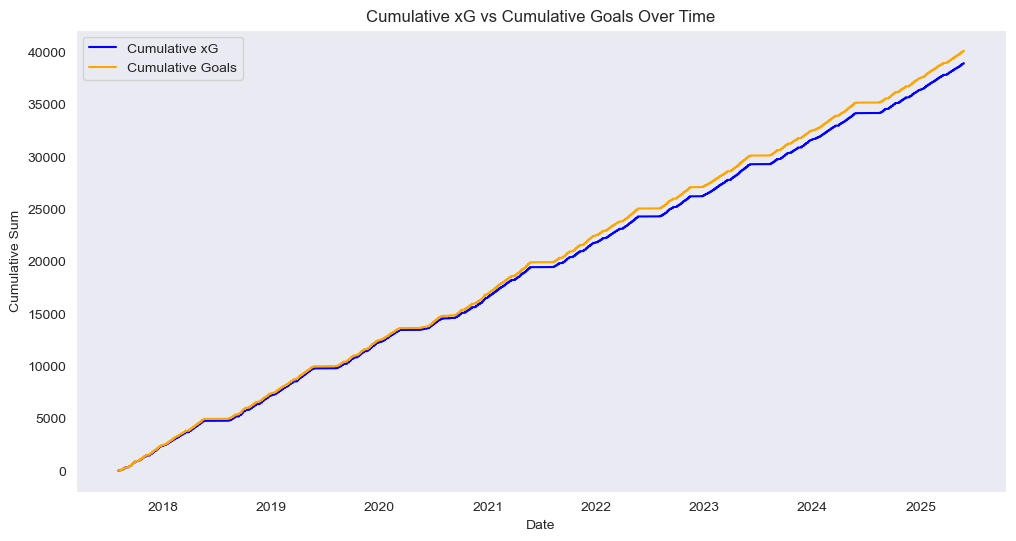

In [7]:
import matplotlib.pyplot as plt
# plot total cumulative xg sum over time and total goals sum over time
df = df.sort_values(by='date')
df['cumulative_xg'] = df['total_xg'].cumsum()
df['cumulative_goals'] = df['total_goals'].cumsum()

# cumsum per season for xg sum and goals sum
df['season'] = df['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_xg'], label='Cumulative xG', color='blue')
plt.plot(df['date'], df['cumulative_goals'], label='Cumulative Goals', color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative xG vs Cumulative Goals Over Time')
plt.legend()
plt.grid()

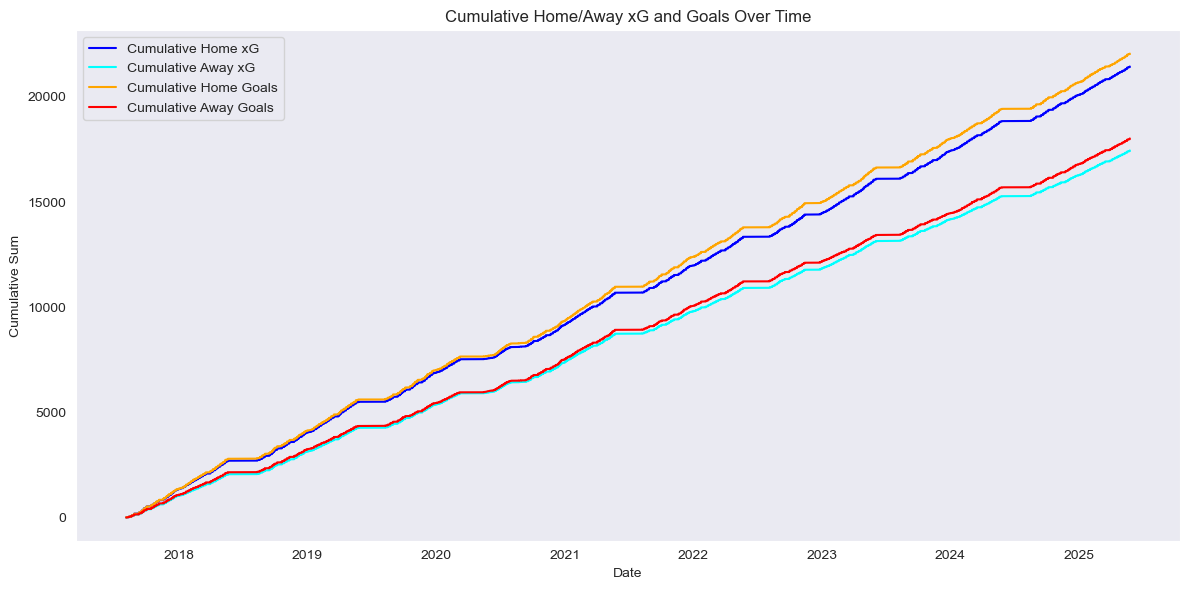

In [8]:
import matplotlib.pyplot as plt

# Sort by date
df = df.sort_values(by='date')

# Cumulative sums for home and away
df['cumulative_home_xg'] = df['home_xg'].cumsum()
df['cumulative_away_xg'] = df['away_xg'].cumsum()
df['cumulative_home_goals'] = df['home_goals'].cumsum()
df['cumulative_away_goals'] = df['away_goals'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_home_xg'], label='Cumulative Home xG', color='blue')
plt.plot(df['date'], df['cumulative_away_xg'], label='Cumulative Away xG', color='cyan')
plt.plot(df['date'], df['cumulative_home_goals'], label='Cumulative Home Goals', color='orange')
plt.plot(df['date'], df['cumulative_away_goals'], label='Cumulative Away Goals', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Home/Away xG and Goals Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

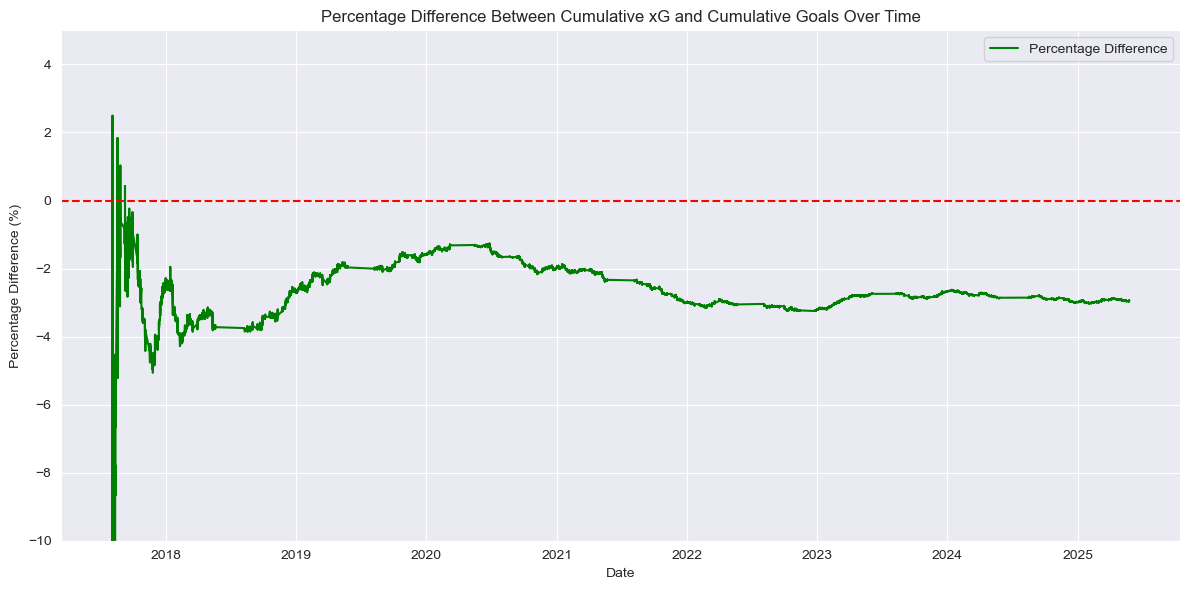

In [9]:
import matplotlib.pyplot as plt

# Compute percentage difference
df['percentage_difference'] = (df['cumulative_xg'] - df['cumulative_goals']) / df['cumulative_goals'] * 100

# Single-axes plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date'], df['percentage_difference'], label='Percentage Difference', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Difference (%)')
ax.set_ylim(-10, 5)
ax.set_title('Percentage Difference Between Cumulative xG and Cumulative Goals Over Time')
ax.axhline(0, color='red', linestyle='--')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
# print last 5 rows of df
df["percentage_difference"].tail()

7596   -2.953092
7595   -2.956163
7597   -2.957310
7593   -2.941250
7600   -2.955396
Name: percentage_difference, dtype: float64

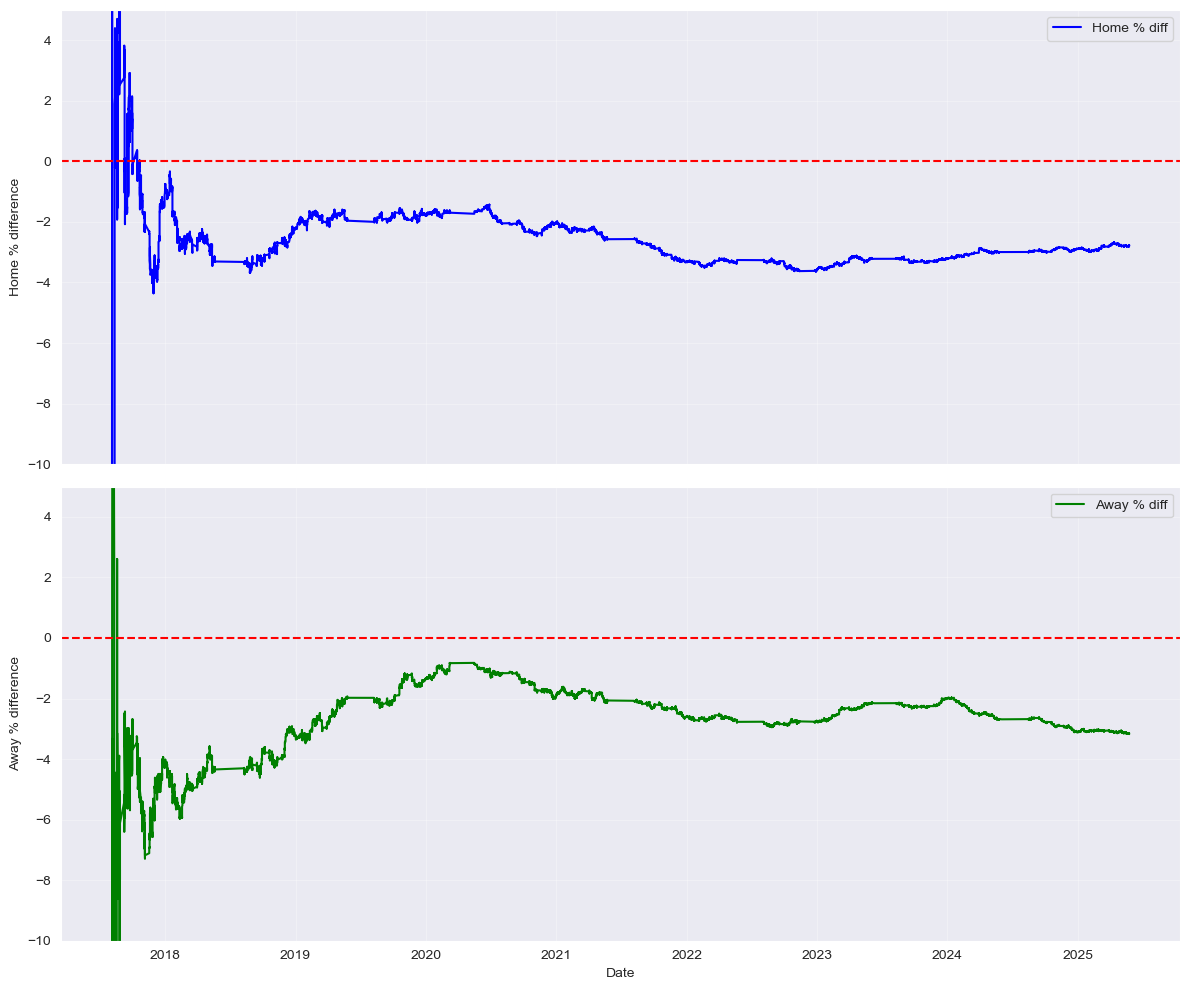

In [11]:

import numpy as np
import matplotlib.pyplot as plt

# Ensure chronological order and required cumulative series
df = df.sort_values("date").copy()
df["cumulative_home_xg"] = df["home_xg"].cumsum()
df["cumulative_away_xg"] = df["away_xg"].cumsum()
df["cumulative_home_goals"] = df["home_goals"].cumsum()
df["cumulative_away_goals"] = df["away_goals"].cumsum()

# Compute home/away percentage differences safely
home_den = df["cumulative_home_goals"]
away_den = df["cumulative_away_goals"]
df["home_percentage_difference"] = np.where(
    home_den > 0,
    (df["cumulative_home_xg"] - home_den) / home_den * 100.0,
    np.nan,
)
df["away_percentage_difference"] = np.where(
    away_den > 0,
    (df["cumulative_away_xg"] - away_den) / away_den * 100.0,
    np.nan,
)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)
axes[0].plot(df["date"], df["home_percentage_difference"], color="blue", label="Home % diff")
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_ylabel("Home % difference")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df["date"], df["away_percentage_difference"], color="green", label="Away % diff")
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Away % difference")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[0].set_ylim(-10, 5)
plt.tight_layout()
plt.show()

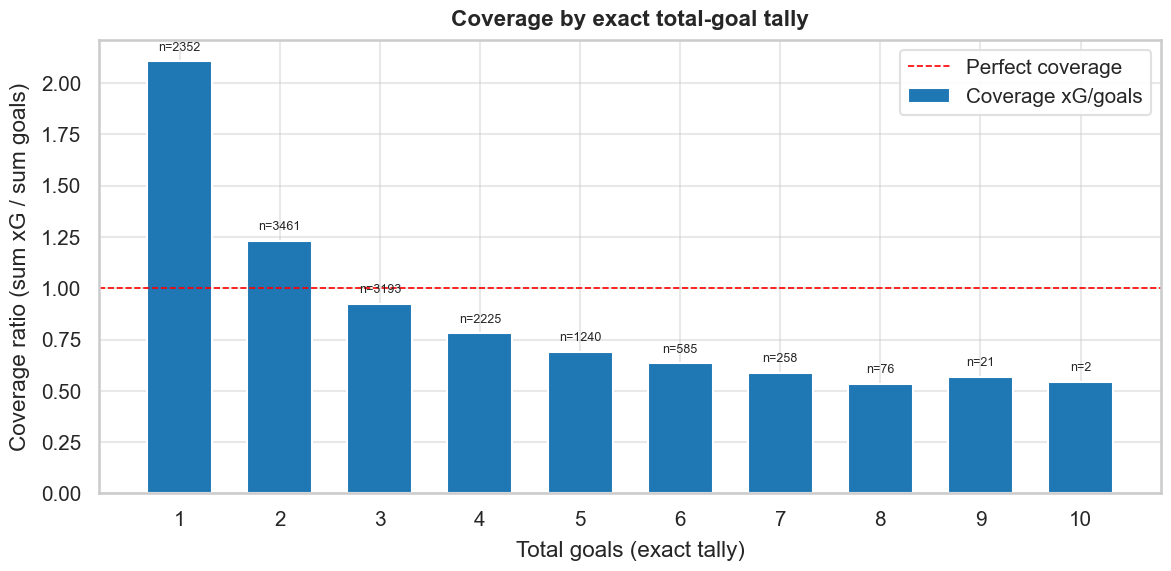

In [31]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prep
d = df.copy()
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']
if 'total_xg' not in d.columns:
    d['total_xg'] = d['home_xg'] + d['away_xg']
d['total_goals'] = d['total_goals'].astype(int)

# Aggregate by exact total-goal tally
agg = (
    d.groupby('total_goals', observed=True)
      .agg(
          matches=('total_goals', 'size'),
          sum_goals=('total_goals', 'sum'),
          sum_xg=('total_xg', 'sum')
      )
      .reset_index()
      .sort_values('total_goals')
)

# Coverage = sum(xG) / sum(goals), undefined at 0-goal -> NaN
agg['coverage'] = np.where(agg['sum_goals'] > 0, agg['sum_xg'] / agg['sum_goals'], np.nan)

# Plot (exclude 0-goal from bars)
plot_df = agg[agg['total_goals'] > 0].copy()

sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(plot_df))
ax.bar(x, plot_df['coverage'], color='#1f77b4', width=0.65, label='Coverage xG/goals')
ax.axhline(1.0, color='red', linestyle='--', linewidth=1.2, label='Perfect coverage')

# Annotations: sample size
for i, (y, n) in enumerate(zip(plot_df['coverage'], plot_df['matches'])):
    if np.isfinite(y):
        ax.annotate(f"n={int(n)}", (i, y), textcoords="offset points", xytext=(0, 8),
                    ha="center", fontsize=9)

ax.set_xticks(x, plot_df['total_goals'].astype(int))
ax.set_xlabel('Total goals (exact tally)')
ax.set_ylabel('Coverage ratio (sum xG / sum goals)')
ax.set_title('Coverage by exact total-goal tally')
ax.legend()
plt.tight_layout()
plt.show()

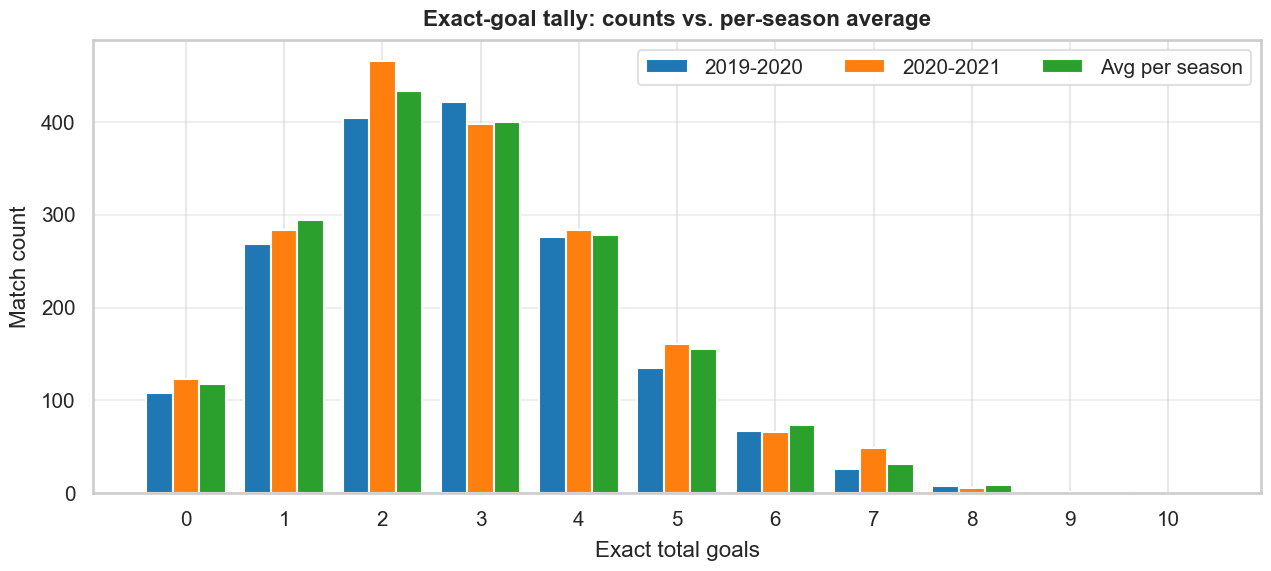

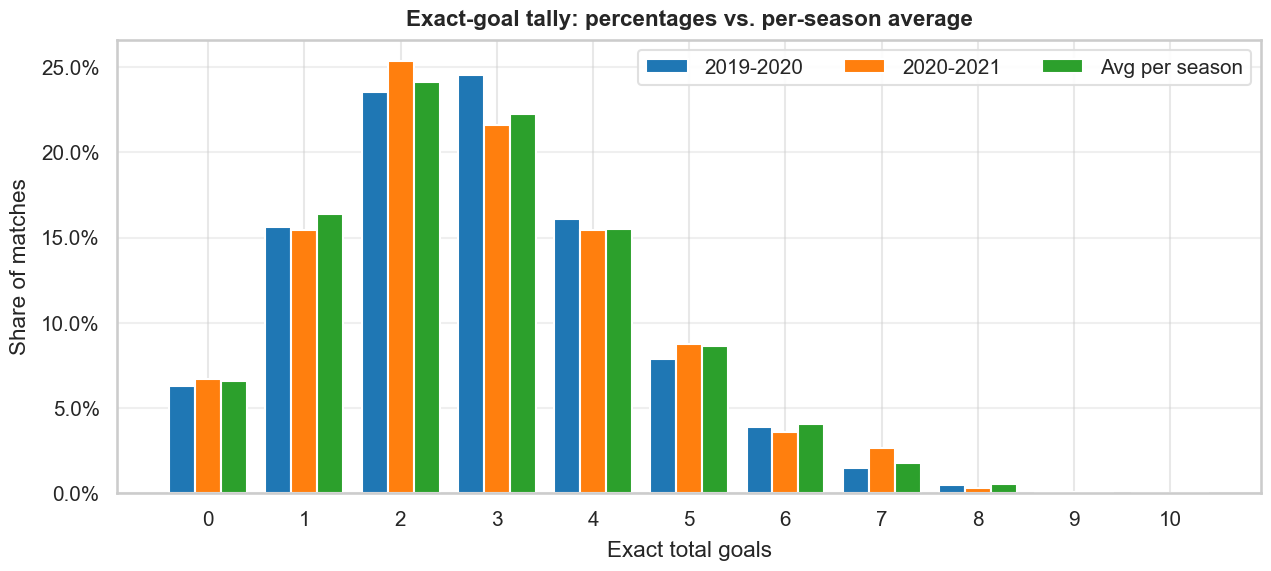

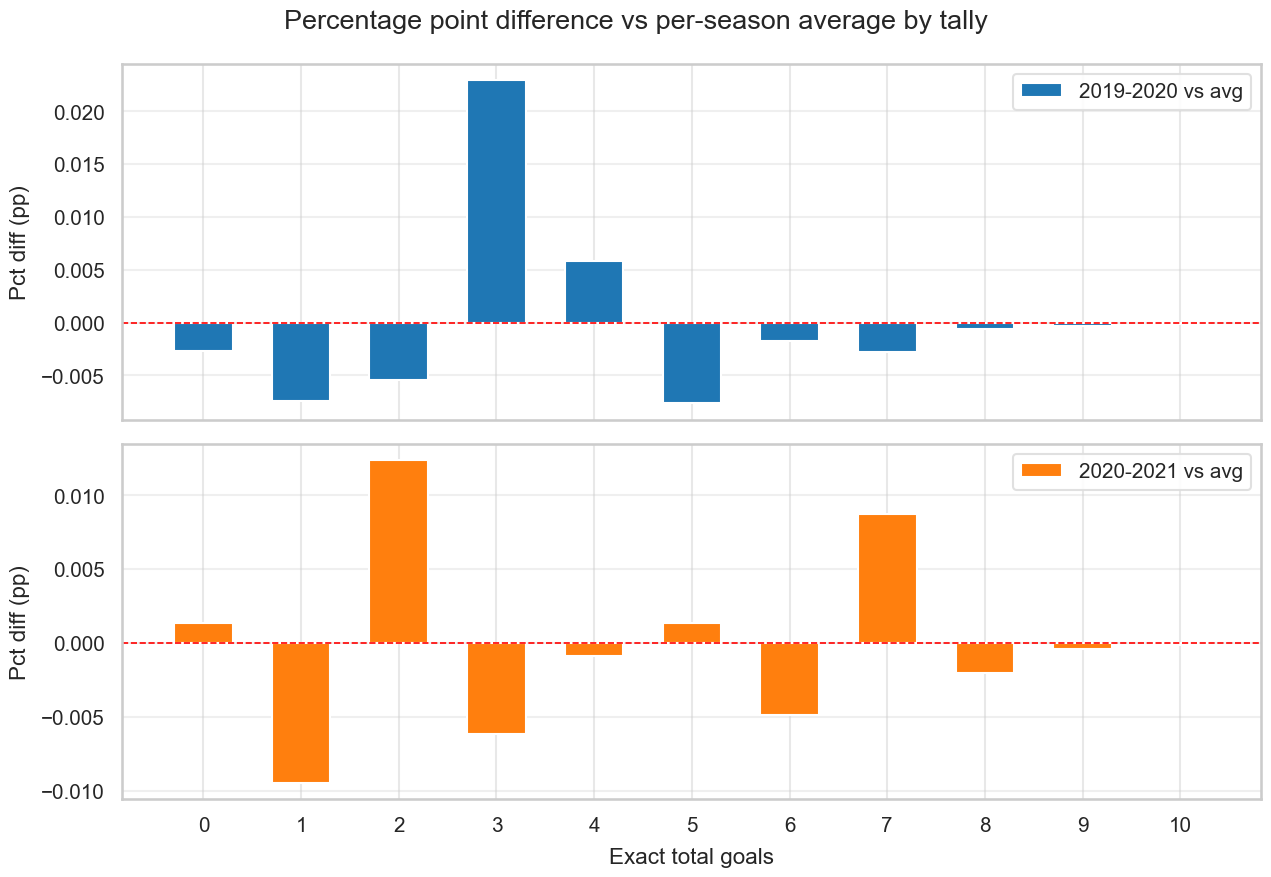

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Expecting a DataFrame `out` with columns:
# ['total_goals','2019-2020','2020-2021','avg_per_season',
#  '2019-2020_pct','2020-2021_pct','avg_pct',
#  '2019-2020_pct_diff','2020-2021_pct_diff']

plot_df = out.copy()
plot_df = plot_df.sort_values('total_goals').reset_index(drop=True)
plot_df['total_goals'] = plot_df['total_goals'].astype(int)

# Extract series (fill NaN for plotting)
c_1920 = plot_df['2019-2020'].fillna(0)
c_2021 = plot_df['2020-2021'].fillna(0)
c_avg  = plot_df['avg_per_season'].fillna(0)

p_1920 = plot_df['2019-2020_pct']
p_2021 = plot_df['2020-2021_pct']
p_avg  = plot_df['avg_pct']

d_1920 = plot_df.get('2019-2020_pct_diff', pd.Series([np.nan]*len(plot_df)))
d_2021 = plot_df.get('2020-2021_pct_diff', pd.Series([np.nan]*len(plot_df)))

x = np.arange(len(plot_df))
w = 0.27

sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)

# 1) Counts: 2019-20 vs 2020-21 vs per-season average
fig, ax = plt.subplots(figsize=(13, 6))
ax.bar(x - w, c_1920, width=w, label='2019-2020', color='#1f77b4')
ax.bar(x,      c_2021, width=w, label='2020-2021', color='#ff7f0e')
ax.bar(x + w,  c_avg,  width=w, label='Avg per season', color='#2ca02c')
ax.set_xticks(x, plot_df['total_goals'].astype(int))
ax.set_xlabel('Exact total goals')
ax.set_ylabel('Match count')
ax.set_title('Exact-goal tally: counts vs. per-season average')
ax.legend(ncol=3)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Percentages: 2019-20 vs 2020-21 vs per-season average
fig, ax = plt.subplots(figsize=(13, 6))
ax.bar(x - w, p_1920, width=w, label='2019-2020', color='#1f77b4')
ax.bar(x,      p_2021, width=w, label='2020-2021', color='#ff7f0e')
ax.bar(x + w,  p_avg,  width=w, label='Avg per season', color='#2ca02c')
ax.set_xticks(x, plot_df['total_goals'].astype(int))
ax.set_xlabel('Exact total goals')
ax.set_ylabel('Share of matches')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title('Exact-goal tally: percentages vs. per-season average')
ax.legend(ncol=3)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Percent difference vs average (per tally)
fig, axes = plt.subplots(2, 1, figsize=(13, 9), sharex=True)
axes[0].bar(x, d_1920, width=0.6, color='#1f77b4', label='2019-2020 vs avg')
axes[1].bar(x, d_2021, width=0.6, color='#ff7f0e', label='2020-2021 vs avg')
for ax in axes:
    ax.axhline(0, color='red', linestyle='--', linewidth=1.2)
    ax.set_ylabel('Pct diff (pp)')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
axes[1].set_xticks(x, plot_df['total_goals'].astype(int))
axes[1].set_xlabel('Exact total goals')
fig.suptitle('Percentage point difference vs per-season average by tally')
plt.tight_layout()
plt.show()

In [33]:
print(out)

NameError: name 'out' is not defined

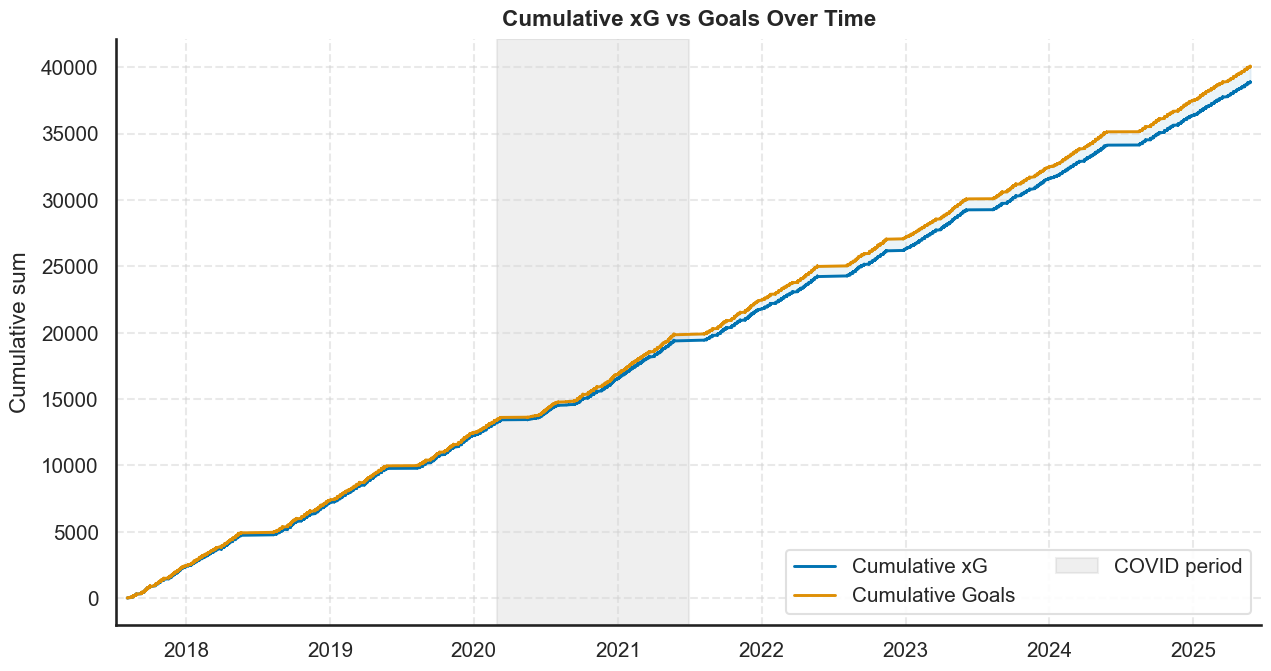

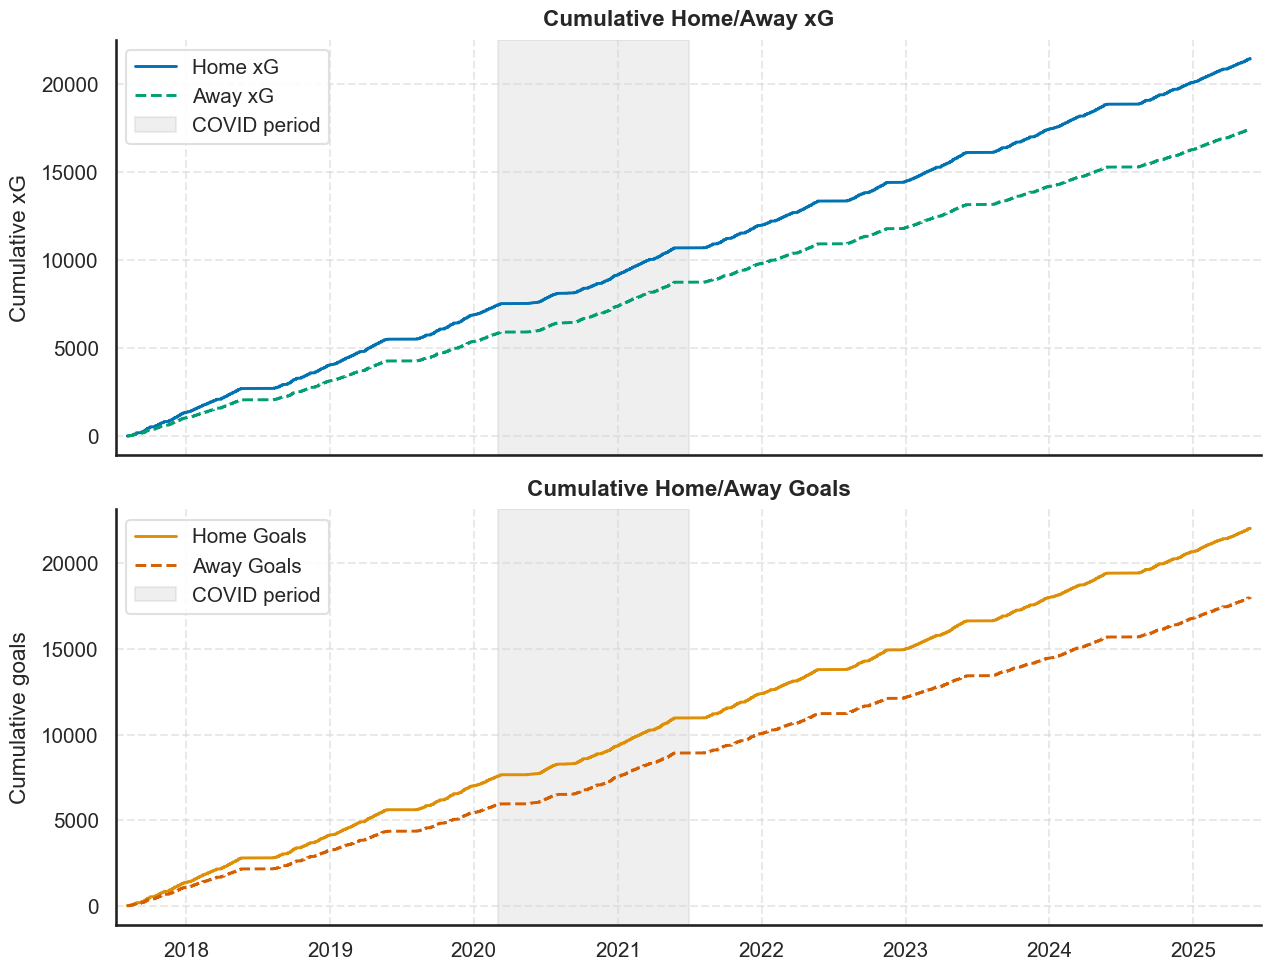

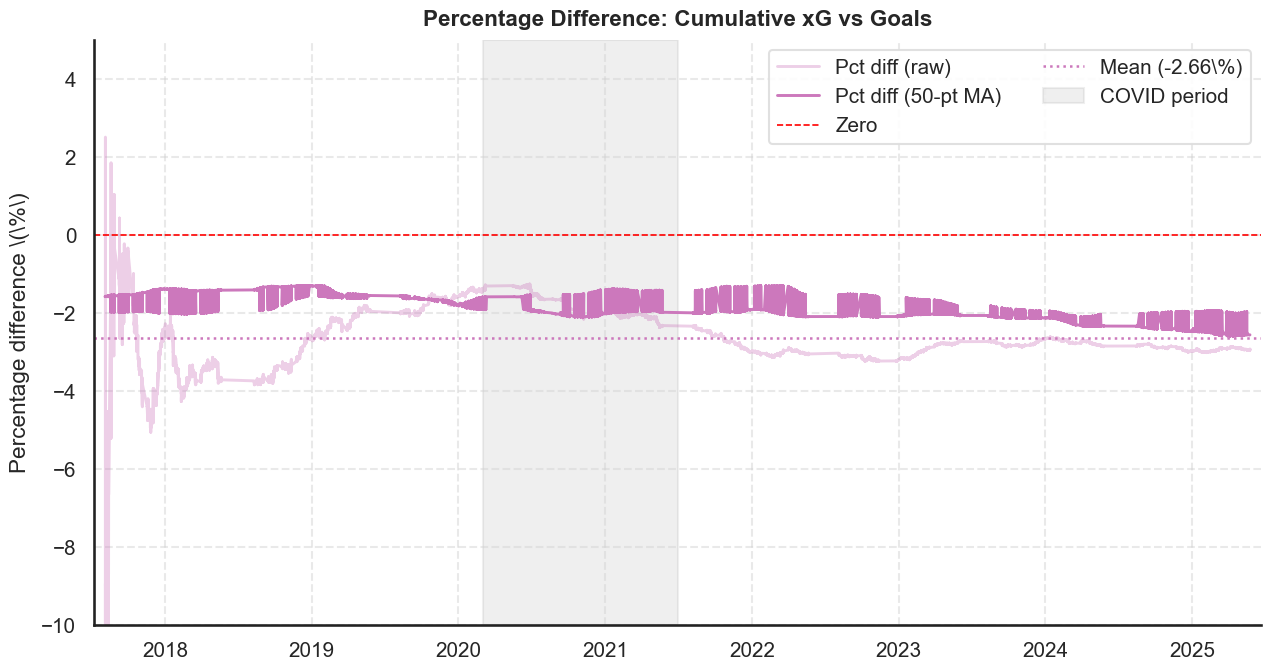

/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_47070/3132552609.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(goal_bins)


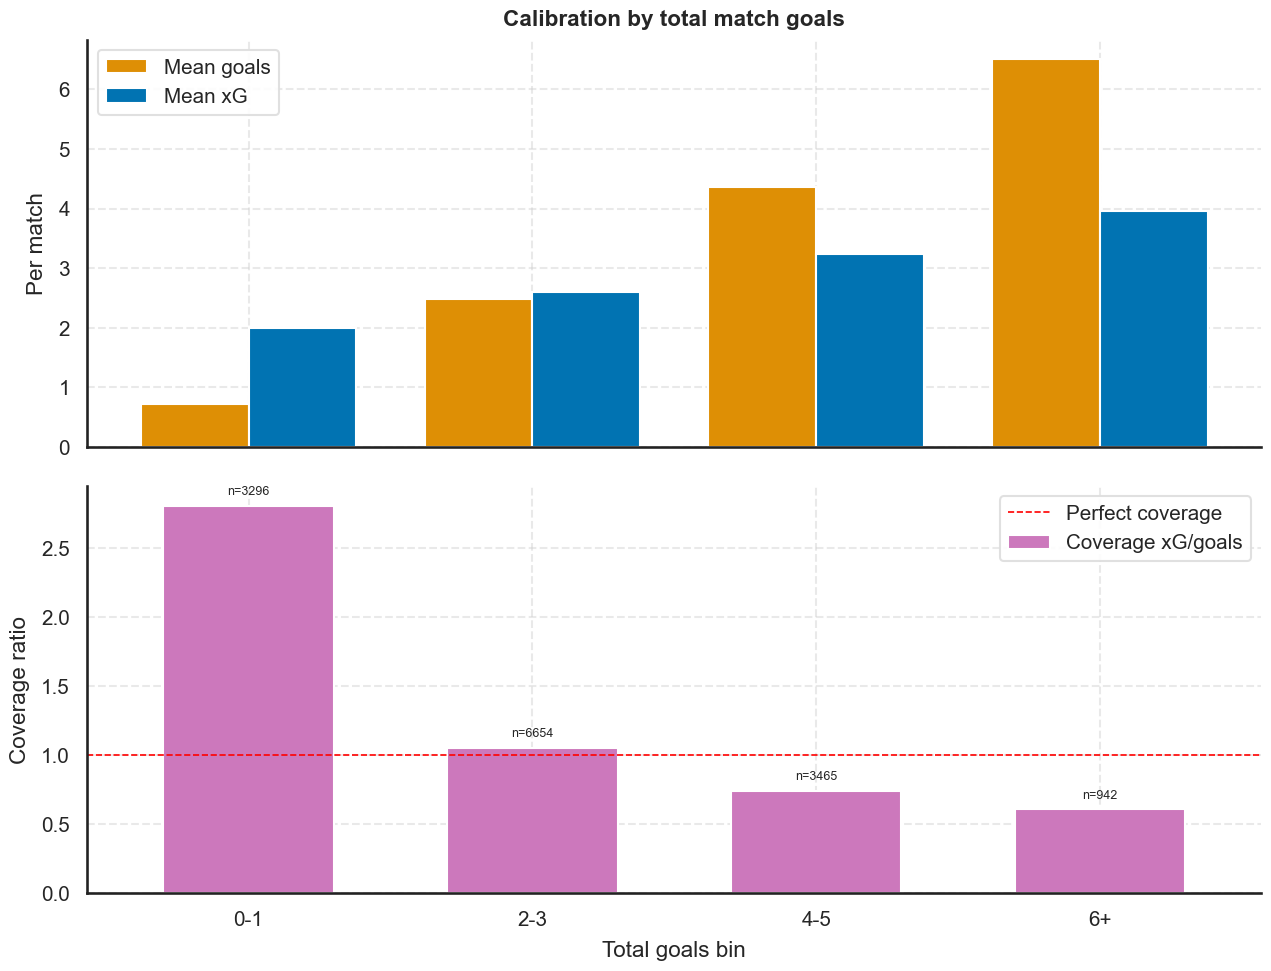

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# -------------------------------------------------------------------
# Global styling
# -------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#222222",
    "axes.titleweight": "semibold",
    "axes.titlepad": 10,
    "axes.labelpad": 8,
    "grid.color": "#D0D0D0",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.edgecolor": "#DDDDDD",
    "legend.fancybox": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2.1,
    "savefig.bbox": "tight",
})
palette = sns.color_palette("colorblind")

covid_start = pd.Timestamp("2020-03-01")
covid_end = pd.Timestamp("2021-06-30")

def format_date_axis(ax):
    loc = AutoDateLocator(minticks=4, maxticks=8)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.margins(x=0.01)

def shade_covid(ax):
    ax.axvspan(covid_start, covid_end, color="gray", alpha=0.12, zorder=0, label="COVID period")

# Ensure sorted and cumulative columns exist
df = df.sort_values("date").copy()
if "cumulative_xg" not in df or "cumulative_goals" not in df:
    df["total_xg"] = df["home_xg"] + df["away_xg"]
    df["total_goals"] = df["home_goals"] + df["away_goals"]
    df["cumulative_xg"] = df["total_xg"].cumsum()
    df["cumulative_goals"] = df["total_goals"].cumsum()

# -------------------------------------------------------------------
# 1) Cumulative xG vs Goals with subtle fill and COVID shading
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(df["date"], df["cumulative_xg"], color=palette[0], label="Cumulative xG")
ax.plot(df["date"], df["cumulative_goals"], color=palette[1], label="Cumulative Goals")

# Subtle fill between curves
ax.fill_between(
    df["date"], df["cumulative_xg"], df["cumulative_goals"],
    color=palette[0], alpha=0.08, zorder=0
)

shade_covid(ax)
format_date_axis(ax)
ax.set_title("Cumulative xG vs Goals Over Time")
ax.set_ylabel("Cumulative sum")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 2) Cumulative Home/Away xG and Goals in two aligned panels
# -------------------------------------------------------------------
# Ensure per-side cumulative series
df["cumulative_home_xg"] = df["home_xg"].cumsum()
df["cumulative_away_xg"] = df["away_xg"].cumsum()
df["cumulative_home_goals"] = df["home_goals"].cumsum()
df["cumulative_away_goals"] = df["away_goals"].cumsum()

fig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

# xG panel
axes[0].plot(df["date"], df["cumulative_home_xg"], color=palette[0], label="Home xG")
axes[0].plot(df["date"], df["cumulative_away_xg"], color=palette[2], linestyle="--", label="Away xG")
shade_covid(axes[0])
format_date_axis(axes[0])
axes[0].set_title("Cumulative Home/Away xG")
axes[0].set_ylabel("Cumulative xG")
axes[0].legend()

# Goals panel
axes[1].plot(df["date"], df["cumulative_home_goals"], color=palette[1], label="Home Goals")
axes[1].plot(df["date"], df["cumulative_away_goals"], color=palette[3], linestyle="--", label="Away Goals")
shade_covid(axes[1])
format_date_axis(axes[1])
axes[1].set_title("Cumulative Home/Away Goals")
axes[1].set_ylabel("Cumulative goals")
axes[1].legend()

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3) Percentage Difference plot with smoothing and reference lines
# -------------------------------------------------------------------
pct = np.where(
    df["cumulative_goals"] > 0,
    (df["cumulative_xg"] - df["cumulative_goals"]) / df["cumulative_goals"] * 100.0,
    np.nan,
)
df["percentage_difference"] = pct
df["percentage_difference_smooth"] = pd.Series(pct).rolling(window=50, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(df["date"], df["percentage_difference"], color=palette[4], alpha=0.35, label="Pct diff (raw)")
ax.plot(df["date"], df["percentage_difference_smooth"], color=palette[4], label="Pct diff (50-pt MA)")
ax.axhline(0, color="red", linestyle="--", linewidth=1.2, label="Zero")
mean_pd = np.nanmean(df["percentage_difference"])
ax.axhline(mean_pd, color=palette[4], linestyle=":", linewidth=1.8, label=f"Mean ({mean_pd:.2f}\\%)")

shade_covid(ax)
format_date_axis(ax)
ax.set_ylim(-10, 5)
ax.set_title("Percentage Difference: Cumulative xG vs Goals")
ax.set_ylabel("Percentage difference \\(\\%\\)")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 4) Calibration by total match goals: prettier bars + coverage
# -------------------------------------------------------------------
# Totals per match (home + away)
df["total_goals"] = df["home_goals"] + df["away_goals"]
df["total_xg"] = df["home_xg"] + df["away_xg"]

# Bins: 0–1, 2–3, 4–5, 6+
edges = [-0.5, 1.5, 3.5, 5.5, np.inf]
labels = ["0-1", "2-3", "4-5", "6+"]
goal_bins = pd.cut(df["total_goals"], bins=edges, labels=labels, right=True, include_lowest=True)

agg = (
    df.groupby(goal_bins)
      .agg(
          matches=("total_goals", "size"),
          mean_goals=("total_goals", "mean"),
          mean_xg=("total_xg", "mean"),
          sum_goals=("total_goals", "sum"),
          sum_xg=("total_xg", "sum"),
      )
      .reset_index(names="bin")
)
agg = agg[agg["matches"] > 0].reset_index(drop=True)
agg["coverage"] = np.where(agg["sum_goals"] > 0, agg["sum_xg"] / agg["sum_goals"], np.nan)

x = np.arange(len(agg))
w = 0.38

fig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True)

# Means panel: grouped bars
axes[0].bar(x - w/2, agg["mean_goals"], width=w, color=palette[1], label="Mean goals")
axes[0].bar(x + w/2, agg["mean_xg"], width=w, color=palette[0], label="Mean xG")
axes[0].set_title("Calibration by total match goals")
axes[0].set_ylabel("Per match")
axes[0].legend()

# Coverage panel: bar + reference line
axes[1].bar(x, agg["coverage"], width=0.6, color=palette[4], label="Coverage xG/goals")
axes[1].axhline(1.0, color="red", linestyle="--", linewidth=1.2, label="Perfect coverage")
axes[1].set_ylabel("Coverage ratio")
axes[1].set_xlabel("Total goals bin")
axes[1].legend()

# Sample sizes and x labels
for i, (y, n) in enumerate(zip(agg["coverage"], agg["matches"])):
    if np.isfinite(y):
        axes[1].annotate(f"n={int(n)}", (i, y), textcoords="offset points", xytext=(0, 8),
                         ha="center", fontsize=9)

axes[1].set_xticks(x, agg["bin"].astype(str))
plt.tight_layout()
plt.show()

      season  matches  avg_goals_per_match  avg_xg_per_match  avg_home_goals  \
0  2017-2018     1826                2.709             2.607           1.530   
1  2018-2019     1826                2.749             2.743           1.544   
2  2019-2020     1715                2.790             2.762           1.543   
3  2020-2021     1835                2.804             2.683           1.478   
4  2021-2022     1825                2.811             2.650           1.548   
5  2022-2023     1827                2.767             2.731           1.558   
6  2023-2024     1752                2.885             2.783           1.592   
7  2024-2025     1751                2.828             2.724           1.500   

   avg_away_goals  
0           1.179  
1           1.205  
2           1.246  
3           1.326  
4           1.262  
5           1.209  
6           1.293  
7           1.327  


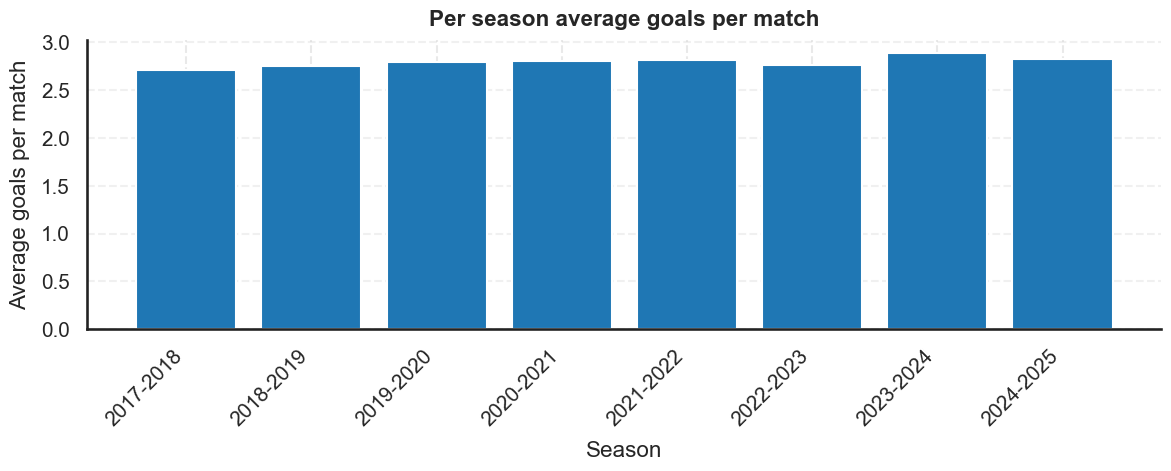

In [15]:

import pandas as pd
import matplotlib.pyplot as plt

# Ensure required columns exist
d = df.copy()
d['date'] = pd.to_datetime(d['date'])
if 'season' not in d.columns:
    d['season'] = d['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']
if 'total_xg' not in d.columns:
    d['total_xg'] = d['home_xg'] + d['away_xg']

# Aggregate per season
per_season = (
    d.groupby('season')
     .agg(
         matches=('total_goals', 'size'),
         avg_goals_per_match=('total_goals', 'mean'),
         avg_xg_per_match=('total_xg', 'mean'),
         avg_home_goals=('home_goals', 'mean'),
         avg_away_goals=('away_goals', 'mean'),
     )
     .reset_index()
)

# Sort seasons chronologically by start year
per_season['season_start'] = per_season['season'].str.split('-', n=1).str[0].astype(int)
per_season = per_season.sort_values('season_start').drop(columns='season_start')

# Round for readability
per_season[['avg_goals_per_match','avg_xg_per_match','avg_home_goals','avg_away_goals']] = \
    per_season[['avg_goals_per_match','avg_xg_per_match','avg_home_goals','avg_away_goals']].round(3)

# Display table
print(per_season)

# Optional: bar plot of average goals per match by season
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(per_season['season'], per_season['avg_goals_per_match'], color='#1f77b4')
ax.set_xlabel('Season')
ax.set_ylabel('Average goals per match')
ax.set_title('Per season average goals per match')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

      season  matches  avg_goals_per_match  avg_xg_per_match  avg_home_goals  \
0  2017-2018     1826                2.709             2.607           1.530   
1  2018-2019     1826                2.749             2.743           1.544   
2  2019-2020     1715                2.790             2.762           1.543   
3  2020-2021     1835                2.804             2.683           1.478   
4  2021-2022     1825                2.811             2.650           1.548   
5  2022-2023     1827                2.767             2.731           1.558   
6  2023-2024     1752                2.885             2.783           1.592   
7  2024-2025     1751                2.828             2.724           1.500   

   avg_away_goals  avg_home_xg  avg_away_xg  
0           1.179        1.480        1.128  
1           1.205        1.534        1.209  
2           1.246        1.510        1.252  
3           1.326        1.416        1.267  
4           1.262        1.457        1.193  
5  

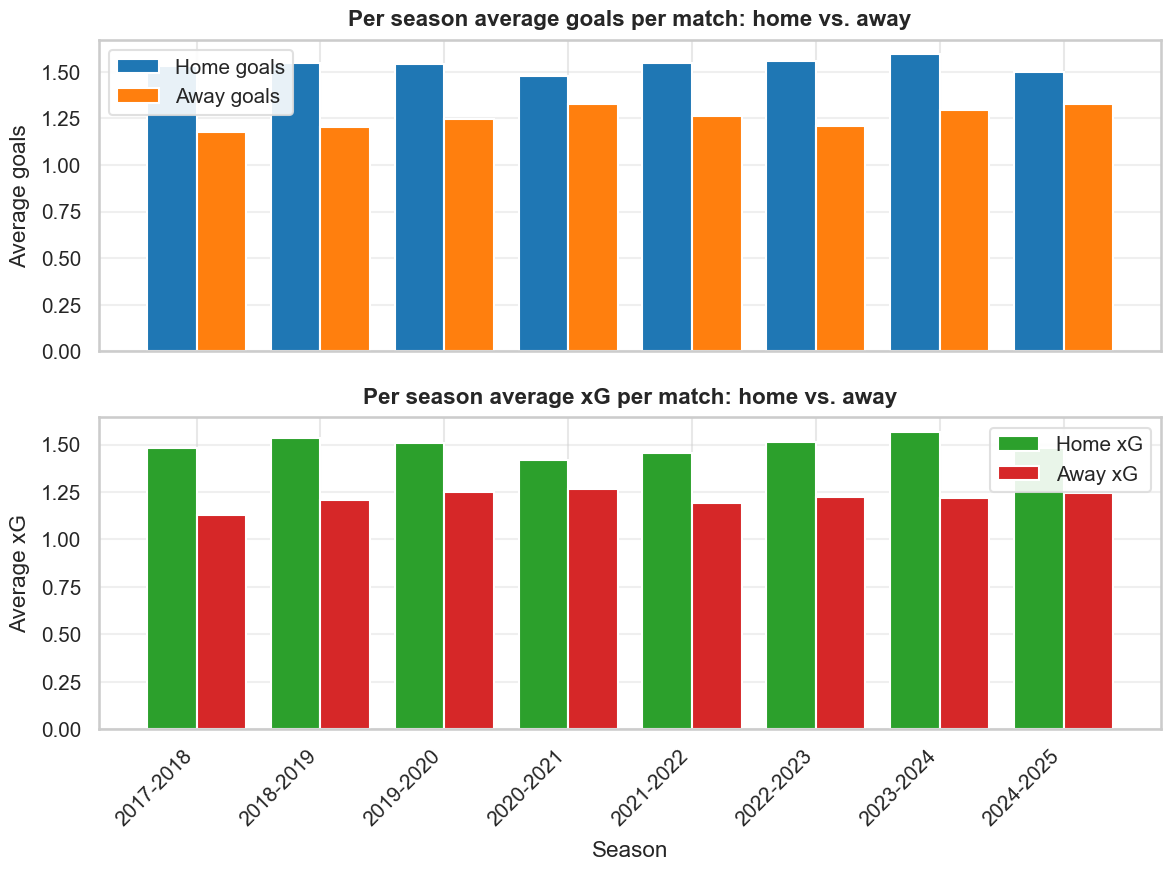

In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data and required columns
d = df.copy()
d['date'] = pd.to_datetime(d['date'])
if 'season' not in d.columns:
    d['season'] = d['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']
if 'total_xg' not in d.columns:
    d['total_xg'] = d['home_xg'] + d['away_xg']

# Aggregate per season (overall + home/away splits)
per_season = (
    d.groupby('season')
     .agg(
         matches=('total_goals', 'size'),
         avg_goals_per_match=('total_goals', 'mean'),
         avg_xg_per_match=('total_xg', 'mean'),
         avg_home_goals=('home_goals', 'mean'),
         avg_away_goals=('away_goals', 'mean'),
         avg_home_xg=('home_xg', 'mean'),
         avg_away_xg=('away_xg', 'mean'),
     )
     .reset_index()
)

# Sort seasons chronologically by start year
per_season['season_start'] = per_season['season'].str.split('-', n=1).str[0].astype(int)
per_season = per_season.sort_values('season_start').drop(columns='season_start')

# Round for readability
cols_to_round = [
    'avg_goals_per_match','avg_xg_per_match',
    'avg_home_goals','avg_away_goals','avg_home_xg','avg_away_xg'
]
per_season[cols_to_round] = per_season[cols_to_round].round(3)

# Display table
print(per_season)

# Plot: grouped bars for home vs. away averages by season
x = np.arange(len(per_season['season']))
w = 0.4

fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Goals: home vs. away
axes[0].bar(x - w/2, per_season['avg_home_goals'], width=w, color='#1f77b4', label='Home goals')
axes[0].bar(x + w/2, per_season['avg_away_goals'], width=w, color='#ff7f0e', label='Away goals')
axes[0].set_title('Per season average goals per match: home vs. away')
axes[0].set_ylabel('Average goals')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()

# xG: home vs. away
axes[1].bar(x - w/2, per_season['avg_home_xg'], width=w, color='#2ca02c', label='Home xG')
axes[1].bar(x + w/2, per_season['avg_away_xg'], width=w, color='#d62728', label='Away xG')
axes[1].set_title('Per season average xG per match: home vs. away')
axes[1].set_ylabel('Average xG')
axes[1].set_xlabel('Season')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.xticks(x, per_season['season'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

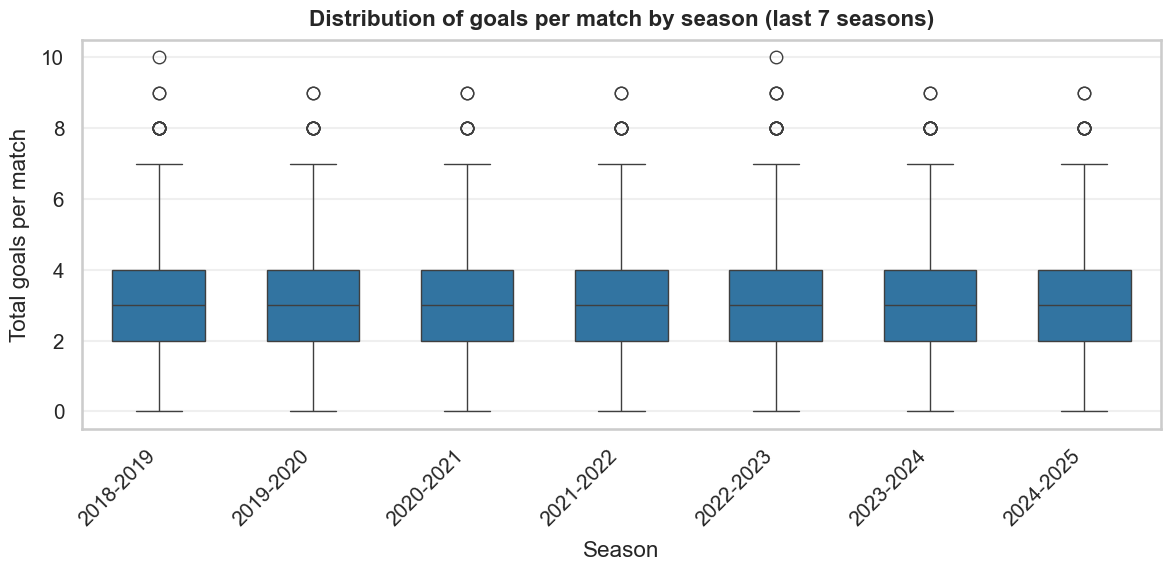

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
d = df.copy()
d['date'] = pd.to_datetime(d['date'])
if 'season' not in d.columns:
    d['season'] = d['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']

# Get season order without .to_series()
season_order = (
    d['season']
      .dropna()
      .astype(str)
      .drop_duplicates()
      .sort_values(key=lambda s: s.str.split('-', n=1).str[0].astype(int))
      .tolist()
)
selected = season_order[-7:] if len(season_order) > 7 else season_order

# Filter and enforce categorical order
d_sel = d[d['season'].isin(selected)].copy()
d_sel['season'] = pd.Categorical(d_sel['season'], categories=selected, ordered=True)

# Plot 7 boxplots
sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=d_sel,
    x='season',
    y='total_goals',
    order=selected,
    width=0.6,
    color='#1f77b4',
)
plt.title('Distribution of goals per match by season (last 7 seasons)')
plt.xlabel('Season')
plt.ylabel('Total goals per match')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

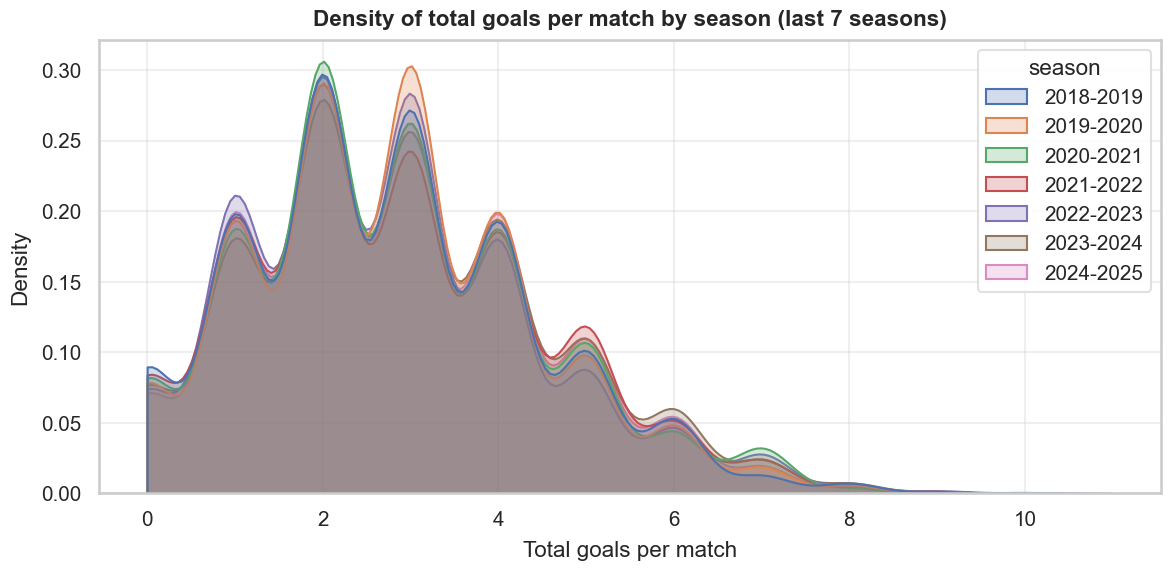

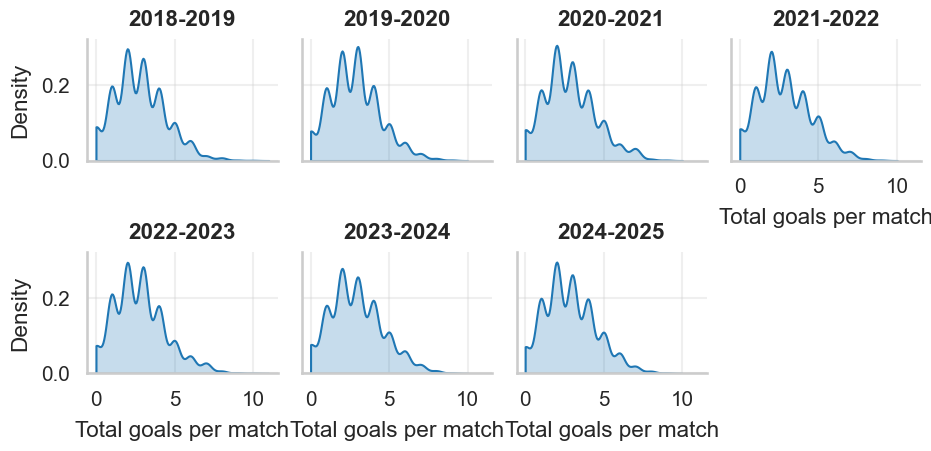

In [18]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
d = df.copy()
d['date'] = pd.to_datetime(d['date'])
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']
if 'season' not in d.columns:
    d['season'] = d['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")

# Select the 7 most recent seasons
season_order = sorted(
    d['season'].dropna().astype(str).unique(),
    key=lambda s: int(s.split('-')[0])
)
selected = season_order[-7:] if len(season_order) > 7 else season_order

# Filter and order
d_sel = d[d['season'].isin(selected)].copy()
d_sel['season'] = pd.Categorical(d_sel['season'], categories=selected, ordered=True)

sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)

# 1) Overlay KDE by season (per-season normalization)
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=d_sel,
    x='total_goals',
    hue='season',
    hue_order=selected,
    fill=True,
    common_norm=False,
    alpha=0.25,
    linewidth=1.5,
    bw_adjust=0.9,
    clip=(0, None),
)
plt.title('Density of total goals per match by season (last 7 seasons)')
plt.xlabel('Total goals per match')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Faceted KDEs (small multiples)
g = sns.FacetGrid(
    d_sel,
    col='season',
    col_order=selected,
    col_wrap=4,
    sharex=True,
    sharey=True,
    height=2.4,
)
g.map_dataframe(sns.kdeplot, x='total_goals', bw_adjust=0.9, fill=True, color='#1f77b4', clip=(0, None))
g.set_axis_labels('Total goals per match', 'Density')
g.set_titles('{col_name}')
for ax in g.axes.flat:
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:

import pandas as pd

# Ensure required columns
d = df.copy()
d['date'] = pd.to_datetime(d['date'])
if 'season' not in d.columns:
    d['season'] = d['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x.month >= 8 else f"{x.year-1}-{x.year}")
if 'total_goals' not in d.columns:
    d['total_goals'] = d['home_goals'] + d['away_goals']
d['total_goals'] = d['total_goals'].astype(int)

# Count exact-goal matches per season -> wide table with columns 0,1,2,...
goals_by_season = (
    d.groupby(['season', 'total_goals'], observed=True)
      .size()
      .unstack(fill_value=0)
)

# Sort seasons chronologically and columns numerically
season_order = sorted(goals_by_season.index, key=lambda s: int(str(s).split('-')[0]))
goals_by_season = goals_by_season.loc[season_order]
goals_by_season = goals_by_season.reindex(sorted(goals_by_season.columns), axis=1)

# Optional: bring season out of index
goals_by_season = goals_by_season.reset_index()

# Result: one row per season; columns 0,1,2,... are counts of N-goal games
goals_by_season

total_goals,season,0,1,2,3,4,5,6,7,8,9,10
0,2017-2018,130,337,419,419,256,165,59,22,13,6,0
1,2018-2019,133,295,444,405,287,150,79,19,11,2,1
2,2019-2020,108,268,404,421,276,135,67,26,8,2,0
3,2020-2021,123,283,465,397,283,161,66,49,6,2,0
4,2021-2022,127,298,444,369,282,180,78,37,8,2,0
5,2022-2023,110,318,445,427,270,131,70,42,10,3,1
6,2023-2024,112,266,413,378,286,161,88,35,11,2,0
7,2024-2025,101,287,427,377,285,157,78,28,9,2,0


In [20]:
# create a dictionary, with season and team as a key and a tuple of (total xg scored, total xg agains, total goals, total goals against) as values
team_stats: Dict[Tuple[int, str], Tuple[float, float, int, int]] = {}

for _, row in df.iterrows():
    season = row['season']
    home_team = row['home_team']
    away_team = row['away_team']
    home_xg = row['home_xg']
    away_xg = row['away_xg']
    home_goals = row['home_goals']
    away_goals = row['away_goals']

    if (season, home_team) not in team_stats:
        team_stats[(season, home_team)] = (0.0, 0.0, 0, 0)
    if (season, away_team) not in team_stats:
        team_stats[(season, away_team)] = (0.0, 0.0, 0, 0)

    home_stats = team_stats[(season, home_team)]
    away_stats = team_stats[(season, away_team)]

    team_stats[(season, home_team)] = (
        home_stats[0] + home_xg,
        home_stats[1] + away_xg,
        home_stats[2] + home_goals,
        home_stats[3] + away_goals
    )
    team_stats[(season, away_team)] = (
        away_stats[0] + away_xg,
        away_stats[1] + home_xg,
        away_stats[2] + away_goals,
        away_stats[3] + home_goals
    )

In [21]:
# create a dataframe from the dictionary
stats_df = pd.DataFrame.from_dict(team_stats, orient='index', columns=['total_xg_scored', 'total_xg_against', 'total_goals_scored', 'total_goals_against'])
stats_df.reset_index(inplace=True)
stats_df[['season', 'team']] = pd.DataFrame(stats_df['index'].tolist(), index=stats_df.index)
stats_df.drop(columns=['index'], inplace=True)

In [22]:
# calculate xg difference and goals difference
stats_df['goals_scored_diff'] = stats_df['total_goals_scored'] - stats_df['total_xg_scored']
stats_df['goals_against_diff'] = stats_df['total_xg_against'] - stats_df['total_goals_against']
stats_df["goals_diff"] = stats_df['goals_scored_diff'] + stats_df['goals_against_diff']

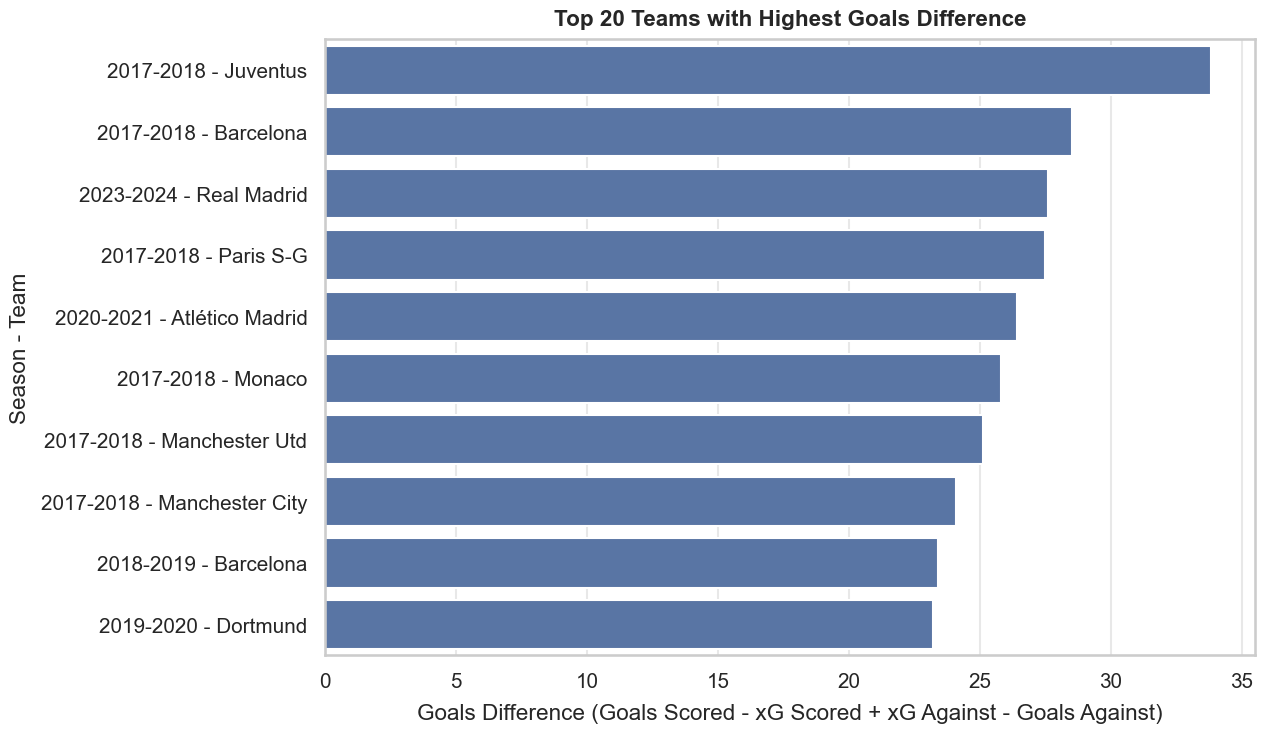

In [23]:
# Combine season and team for y-axis labels
top_20_teams_unique = stats_df.sort_values(by='goals_diff', ascending=False).head(10)
top_20_teams_unique['season_team'] = top_20_teams_unique['season'] + ' - ' + top_20_teams_unique['team']

pltl.pyplot.figure(figsize=(12, 8))
sns.barplot(x='goals_diff', y='season_team', data=top_20_teams_unique)
pltl.pyplot.title('Top 20 Teams with Highest Goals Difference')
pltl.pyplot.xlabel('Goals Difference (Goals Scored - xG Scored + xG Against - Goals Against)')
pltl.pyplot.ylabel('Season - Team')
pltl.pyplot.show()

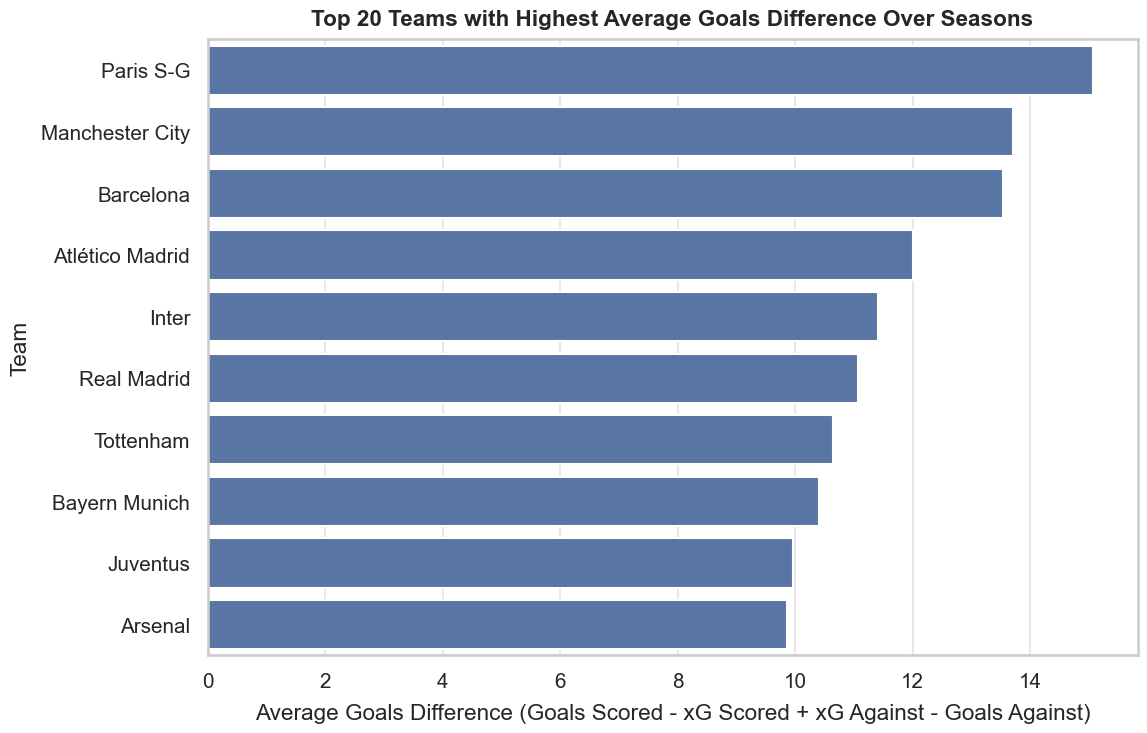

In [24]:
average_over_team = stats_df.groupby('team')['goals_diff'].mean().reset_index()
average_over_team = average_over_team.sort_values(by='goals_diff', ascending=False).head(10)
pltl.pyplot.figure(figsize=(12, 8))
sns.barplot(x='goals_diff', y='team', data=average_over_team)
pltl.pyplot.title('Top 20 Teams with Highest Average Goals Difference Over Seasons')
pltl.pyplot.xlabel('Average Goals Difference (Goals Scored - xG Scored + xG Against - Goals Against)')
pltl.pyplot.ylabel('Team')
pltl.pyplot.show()

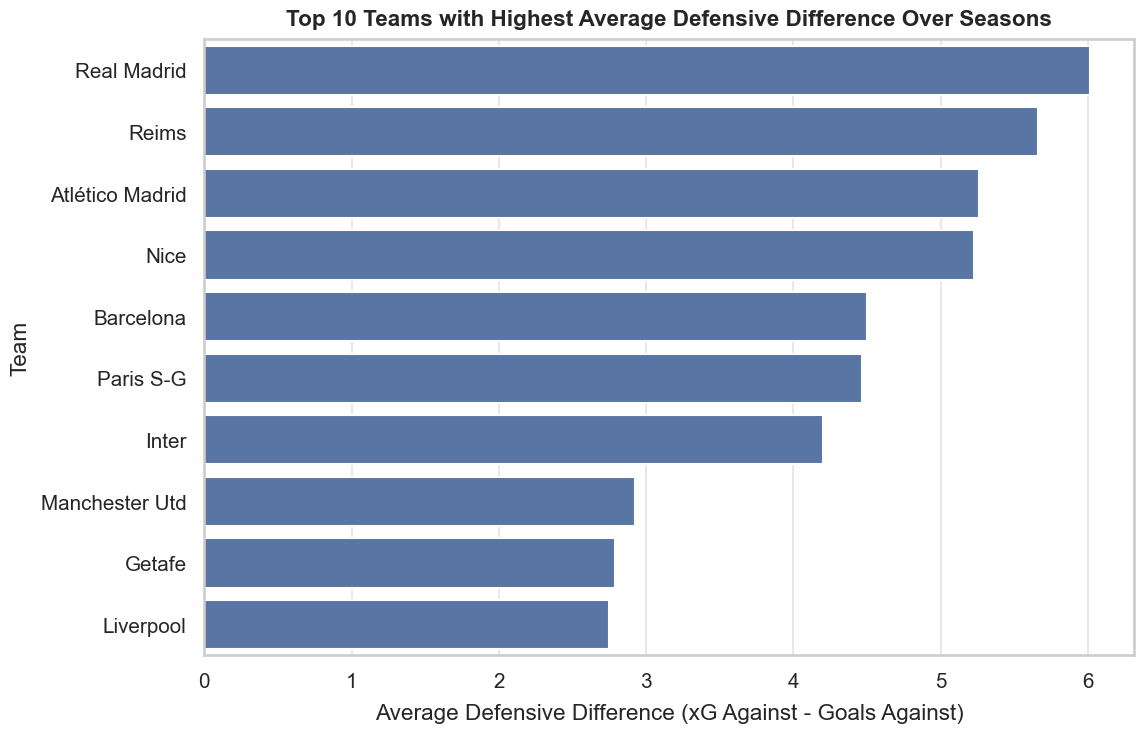

In [25]:
# Calculate average defensive difference per team
# check only for teams with more than 3 seasons
team_season_counts = stats_df['team'].value_counts()
teams_with_multiple_seasons = team_season_counts[team_season_counts > 6].index
stats_df = stats_df[stats_df['team'].isin(teams_with_multiple_seasons)]
average_defence_over_team = stats_df.groupby('team')['goals_against_diff'].mean().reset_index()
average_defence_over_team = average_defence_over_team.sort_values(by='goals_against_diff', ascending=False).head(10)

pltl.pyplot.figure(figsize=(12, 8))
sns.barplot(x='goals_against_diff', y='team', data=average_defence_over_team)
pltl.pyplot.title('Top 10 Teams with Highest Average Defensive Difference Over Seasons')
pltl.pyplot.xlabel('Average Defensive Difference (xG Against - Goals Against)')
pltl.pyplot.ylabel('Team')
pltl.pyplot.show()

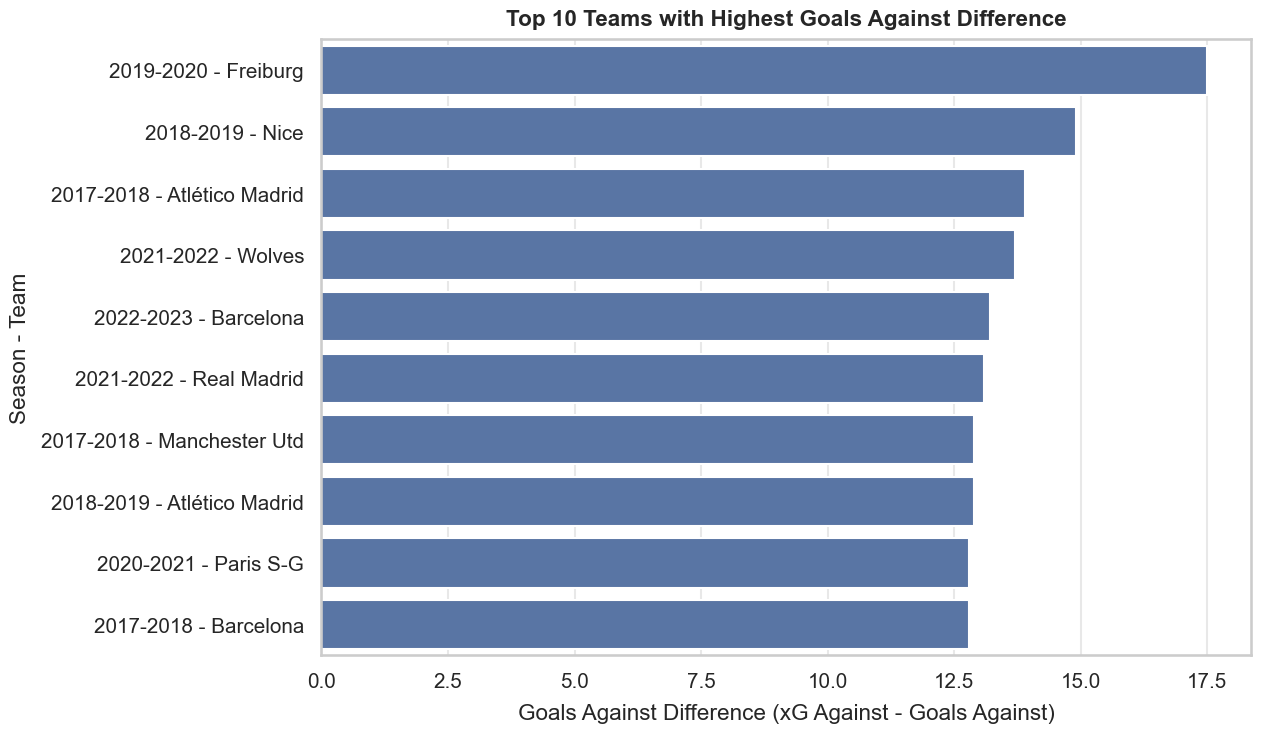

In [26]:
# Combine season and team for y-axis labels
top_20_teams_unique = stats_df.sort_values(by='goals_against_diff', ascending=False).head(10)
top_20_teams_unique['season_team'] = top_20_teams_unique['season'] + ' - ' + top_20_teams_unique['team']

pltl.pyplot.figure(figsize=(12, 8))
sns.barplot(x='goals_against_diff', y='season_team', data=top_20_teams_unique)
pltl.pyplot.title('Top 10 Teams with Highest Goals Against Difference')
pltl.pyplot.xlabel('Goals Against Difference (xG Against - Goals Against)')
pltl.pyplot.ylabel('Season - Team')
pltl.pyplot.show()

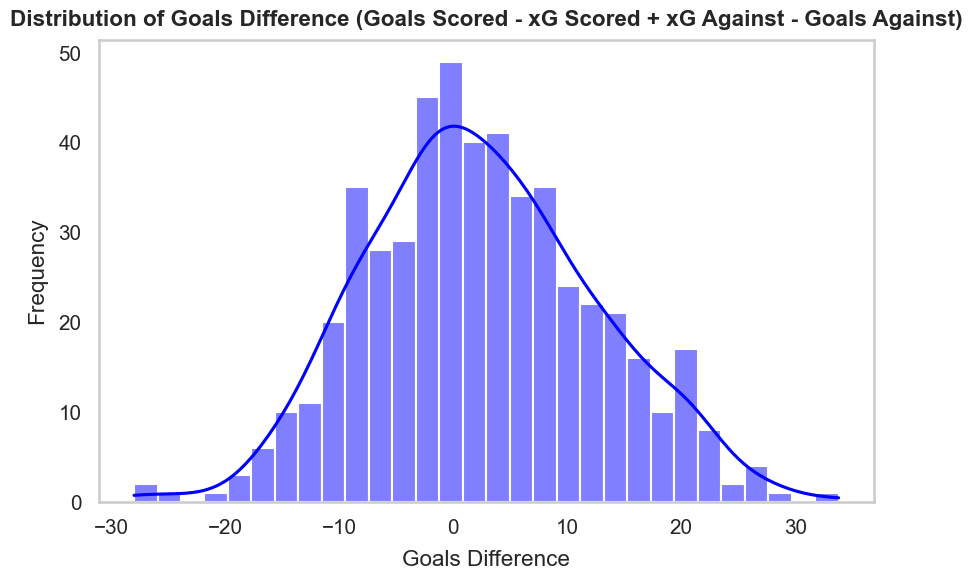

In [27]:
# plot the distribution of goals_diff
pltl.pyplot.figure(figsize=(10, 6))
sns.histplot(stats_df['goals_diff'], bins=30, kde=True, color='blue')
pltl.pyplot.title('Distribution of Goals Difference (Goals Scored - xG Scored + xG Against - Goals Against)')
pltl.pyplot.xlabel('Goals Difference')
pltl.pyplot.ylabel('Frequency')
pltl.pyplot.grid()
pltl.pyplot.show()

In [28]:
# mean of goals_diff
mean_goals_diff = stats_df['goals_diff'].mean()
print(mean_goals_diff)


2.4406976744186046
